In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision.transforms as transforms
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

In [3]:
class ParticleDataset(Dataset):
    def __init__(self, hdf5_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        for idx, file in enumerate(hdf5_files):
            with h5py.File(file, 'r') as f:
                X = f['X'][:]
                y = np.full((X.shape[0],), idx)
                self.data.append(X)
                self.labels.append(y)
        
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img[:,:,0], img[:,:,1], label

In [4]:
full_dataset = ParticleDataset(['/kaggle/input/cms-particle-collison/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 
                                '/kaggle/input/cms-particle-collison/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'])


In [5]:
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset,batch_size = 32,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = 32,shuffle = True)
print("Data loaded")

Data loaded


In [7]:
import torch.nn.functional as F

In [8]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet15(nn.Module):
    def __init__(self, num_classes=1):  
        super(ResNet15, self).__init__()

        self.conv1_a = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1_a = nn.BatchNorm2d(64)

        self.conv1_b = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1_b = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(128, 128, 2, stride=1)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x1, x2):
        out1 = F.relu(self.bn1_a(self.conv1_a(x1)))

        out2 = F.relu(self.bn1_b(self.conv1_b(x2)))

        out = torch.cat((out1, out2), dim=1)  

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)  
        out = torch.flatten(out, 1)
        out = self.fc(out)
        out = F.sigmoid(out)
        return out


In [9]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, downsample=False):
#         super(ResidualBlock, self).__init__()
#         stride = 2 if downsample else 1  
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.shortcut = nn.Sequential()
#         if downsample or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         identity = self.shortcut(x)
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out += identity 
#         out = self.relu(out)
#         return out

# class ResNet15(nn.Module):
#     def __init__(self, num_classes=1):
#         super(ResNet15, self).__init__()
#         self.ch1_conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.ch1_bn1 = nn.BatchNorm2d(64)
        
#         self.ch2_conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.ch2_bn1 = nn.BatchNorm2d(64)
        
#         self.relu = nn.ReLU(inplace=True)
        
#         self.ch2_layer1 = self._make_res_layers(64, 128, blocks=2, downsample=True)
#         # self.ch2_layer2 = self._make_res_layers(64, 128, blocks=2, downsample=True)
#         self.ch2_layer3 = self._make_res_layers(128, 256, blocks=2, downsample=True)
#         # self.ch2_layer4 = self._make_res_layers(256, 512, blocks=2, downsample=True)

#         self.ch1_layer1 = self._make_res_layers(64, 128, blocks=2, downsample=True)
#         # self.ch1_layer2 = self._make_res_layers(64, 128, blocks=2, downsample=True)
#         self.ch1_layer3 = self._make_res_layers(128, 256, blocks=2, downsample=True)
#         # self.ch1_layer4 = self._make_res_layers(256, 512, blocks=2, downsample=True)
#         # self.layer5 = self._make_res_layers(512, 256, blocks=2, downsample=True)
#         # self.layer6 = self._make_res_layers(256, 128, blocks=2, downsample=False)
#         # self.layer7 = self._make_res_layers(128, 64, blocks=2, downsample=False)
#         # self.layer8 = self._make_res_layers(64, 64, blocks=2, downsample=False)
        

#         self.ch1_fc1 = nn.Linear(32768, 1024)
#         # self.ch1_fc2 = nn.Linear(1024, 64)
#         # # self.ch1_fc3 = nn.Linear(256, 128)
#         self.ch1_fc = nn.Linear(1024, num_classes)
        
#         # self.ch2_fc1 = nn.Linear(8192, num_classes)
#         # self.ch2_fc2 = nn.Linear(1024, 256)
#         # # self.ch2_fc3 = nn.Linear(256, 128)
#         # self.ch2_fc = nn.Linear(256, num_classes)
        
#         self.sigmoid = nn.Sigmoid()

#     def _make_res_layers(self, in_channels, out_channels, blocks, downsample):
#         layers = []
#         layers.append(ResidualBlock(in_channels, out_channels, downsample=downsample))
#         for _ in range(1, blocks):
#             layers.append(ResidualBlock(out_channels, out_channels, downsample=False))
#         return nn.Sequential(*layers)

#     def _forward_features(self, x1,x2):
#         x1 = self.ch1_conv1(x1)
#         x1 = self.ch1_bn1(x1)
#         x1 = self.relu(x1)
#         x1 = self.ch1_layer1(x1)
#         # x1 = self.ch1_layer2(x1)
#         x1 = self.ch1_layer3(x1)
#         # x1 = self.ch1_layer4(x1)

#         x2 = self.ch2_conv1(x2)
#         x2 = self.ch2_bn1(x2)
#         x2 = self.relu(x2)
#         x2 = self.ch2_layer1(x2)
#         # x2 = self.ch2_layer2(x2)
#         x2 = self.ch2_layer3(x2)
#         # x2 = self.ch2_layer4(x2)
#         # x = self.layer5(x)
#         # x = self.layer6(x)
#         # x = self.layer7(x)
#         # x = self.layer8(x)
#         return x1, x2

#     def forward(self, x1,x2):
#         batch = x1.shape[0]
#         # print("x shape:",x.shape)
#         x1,x2 = self._forward_features(x1,x2)
#         # x1 = self._forward_features(x1)
#         # x2 = self._forward_features(x2)
#         # print("X1 shape:",x1.shape," X2 shape:",x2.shape)
#         x = x1+x2
#         x = torch.concat([x1,x2],dim =1)
#         print("X shape",x.shape)
#         x = x.view(batch,-1)
#         print("X shape",x.shape)
#         # x = x.view(batch,-1)
#         # x1 = x1.reshape(batch, -1)
#         # x2 = x2.reshape(batch, -1)
#         # print("X1 shape:",x1.shape," X2 shape:",x2.shape)
#         # print(x.shape)
#         x = self.ch1_fc1(x)
#         # x = self.ch1_fc2(x)
#         # x1 = self.ch1_fc3(x1)
#         x = self.ch1_fc(x)

#         # x2 = self.ch2_fc1(x2)
#         # x2 = self.ch2_fc2(x2)
#         # # x2 = self.ch2_fc3(x2)
#         # x2 = self.ch2_fc(x2)
#         # print("X1 shape:",x1.shape," X2 shape:",x2.shape)
#         # x = x1+x2
#         # print("Concat X shape:",x.shape)
#         x = self.sigmoid(x)
#         return x
        

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet15().to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=40)
print("Model Created")

Model Created


In [11]:
# from tqdm import tqdm

In [12]:
num_epochs = 50
train_losses = []
print("Training started...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # acc_loss = 0
    count = 0
    for img1,img2, labels in (train_loader):
        # print("img shape in loader: ",img1.shape)
        # img = img.permute(0, 3, 1, 2)
        # print("Label shape:", labels.shape)
        # print(labels)
        batch = img1.shape[0]
        img1,img2, labels = img1.to(device),img2.to(device), labels.to(device)
        img1 = img1.view(batch,1,32,32)
        # print("img shape in loader: ",img1.shape)
        img2 = img2.view(batch,1,32,32)
        optimizer.zero_grad()
        outputs = model(img1,img2)
        # print("Output shape:", outputs.shape)
        # print(outputs)
        
        labels = labels.float()
        outputs = outputs.view(-1)
        # print("Output shape:", outputs.shape, "Output dtype:", outputs.dtype)
        # print("Label shape:", labels.shape, "Label dtype:", labels.dtype)
        loss = criterion(outputs, labels)
        # print(loss)
        # acc_loss += loss
        count+=1
        # if count %100==0:
        #     print(acc_loss/count)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Loss: {running_loss/count}")
    train_losses.append(running_loss/count)

print("Training Finished")

Training started...
Loss: 0.5918971218761191
Loss: 0.5583701790001497
Loss: 0.5490537451381186
Loss: 0.5442014886600426
Loss: 0.5403433905332443
Loss: 0.5372819563159981
Loss: 0.5350493599731759
Loss: 0.5330264943885995
Loss: 0.5306217237050275
Loss: 0.5282131755615334
Loss: 0.5257458474908967
Loss: 0.5237022580679161
Loss: 0.5208496096048011
Loss: 0.5180644132956922
Loss: 0.5148176540189
Loss: 0.5101966397027414
Loss: 0.5047020539892725
Loss: 0.4964261082987709
Loss: 0.48569670734755005
Loss: 0.4700968554209035
Loss: 0.4496946616847831
Loss: 0.42354490299780206
Loss: 0.3927110973072339
Loss: 0.36048213277595587
Loss: 0.32824490973568826
Loss: 0.2966570894976696
Loss: 0.2671622339863495
Loss: 0.24085952368097371
Loss: 0.21558944423933585
Loss: 0.19413786915336628
Loss: 0.1752238166038261
Loss: 0.15833428534002128
Loss: 0.14261104156775586
Loss: 0.12954482039257165
Loss: 0.11851515242792517
Loss: 0.10831647383838323
Loss: 0.10010486086615432
Loss: 0.09255268544075547
Loss: 0.08609466269

In [13]:
torch.save(model.state_dict(), "resnet15_like_weights.pth")

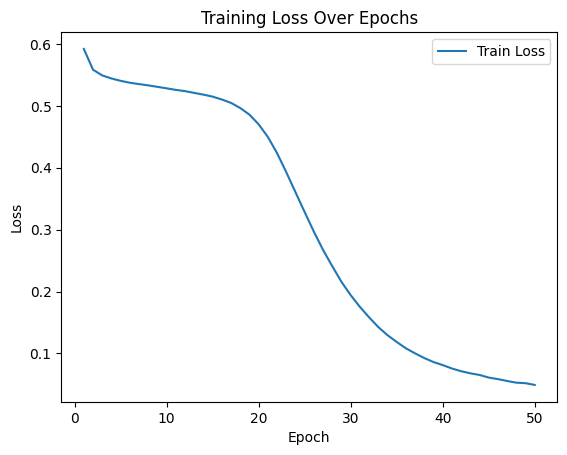

In [14]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

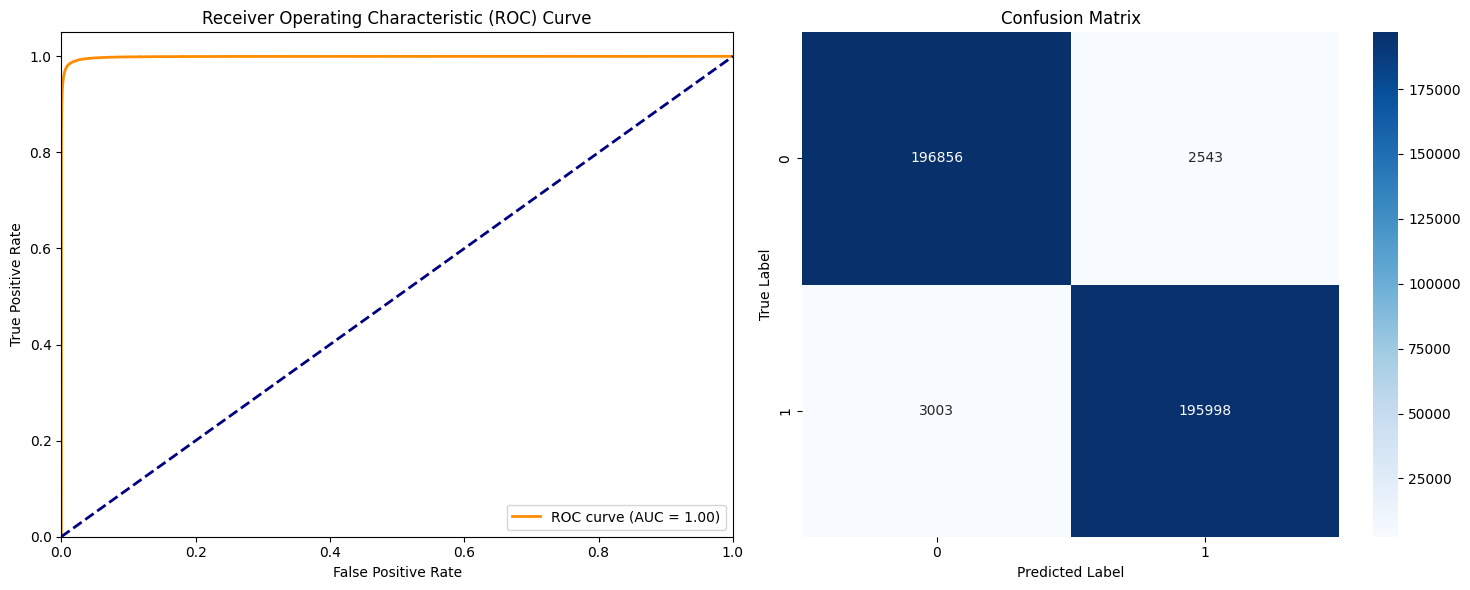

AUC Score: 0.9990
Optimal Threshold: 0.5225
Precision: 0.9872
Recall: 0.9849
F1 Score: 0.9860
Accuracy: 0.9861


In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns


model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for img1,img2, labels in (train_loader):
        # print(img1.shape)
        batch = img1.shape[0]
        img1,img2, labels = img1.to(device),img2.to(device), labels.to(device)
        img1 = img1.view(batch,1,32,32)
        img2 = img2.view(batch,1,32,32)
        outputs = model(img1,img2)
            
        # probabilities = outputs.cpu().numpy()[:, 1]
        probabilities = outputs.cpu().numpy().flatten()
            
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probabilities)
        
y_true = np.array(y_true)
y_scores = np.array(y_scores)
    

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
ax1.plot(fpr, tpr, color='darkorange', lw=2,label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")
    
y_pred = (y_scores >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title('Confusion Matrix')
    
plt.tight_layout()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
    

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
    
print(f"AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {np.mean(y_pred == y_true):.4f}")